## Instalando bibliotecas necessárias

In [1]:
!pip install pandas==1.3.5 matplotlib==3.5.3 seaborn==0.12.2 gdown==4.7.3

     ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.7 MB ? eta -:--:--
      --------------------------------------- 0.1/4.7 MB 991.0 kB/s eta 0:00:05
      --------------------------------------- 0.1/4.7 MB 991.0 kB/s eta 0:00:05
      --------------------------------------- 0.1/4.7 MB 991.0 kB/s eta 0:00:05
     - -------------------------------------- 0.2/4.7 MB 766.6 kB/s eta 0:00:06
     - -------------------------------------- 0.2/4.7 MB 766.6 kB/s eta 0:00:06
     -- ------------------------------------- 0.3/4.7 MB 936.6 kB/s eta 0:00:05
     -- ------------------------------------- 0.3/4.7 MB 936.6 kB/s eta 0:00:05
     -- ------------------------------------- 0.3/4.7 MB 936.6 kB/s eta 0:00:05
     -- ------------------------------------- 0.3/4.7 MB 936.6 kB/s eta 0:00:05
     -- ------------------------------------- 0.3/4.7 MB 746.0 kB/s eta 0:00:06
     -- ------------------------------------- 0.3/4.7 MB 7

  error: subprocess-exited-with-error
  
  × Building wheel for pandas (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [2474 lines of output]
      <string>:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-312
      creating build\lib.win-amd64-cpython-312\pandas
      copying pandas\conftest.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\testing.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\_typing.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\_version.py -> build\lib.win-amd64-cpython-312\pandas
      copying pandas\__init__.py -> build\lib.win-amd64-cpython-312\pandas
      creating build\lib.win-amd64-cpython-312\pandas\api
      copying pandas\api\__init__.py -> build\lib.win-amd64-cpython-312\pandas\a

# Algoritmo para calcular taxa de retenção
Esse notebook contempla a análise exploratória sobre a retenção de profissionais nas regiões de saúde com base em dados do CNES-PF. O notebook contém o script principal e métodos auxiliares, que ajudam a tratar os dados e criar algumas visualizações.

Observação:
```
Antes de executar o notebook é necessário criar 3 pastas:
- imgs
- csvs
- dados
```

## Carregar bibliotecas

In [4]:
import traceback
import warnings
from operator import attrgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown

## Configurar bibliotecas

In [ ]:
# Remover limite de exibição de linhas e colunas do pandas
pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

# Evitar notações científicas no pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Evitar warnings sobre perfomance no pandas
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Funções auxiliares para tratamento dos dados

In [6]:
def gerar_triangulo_agregado(df_tmp):
    # Converter a coluna competência para o formato ANO-MES (datetime)
    df_tmp['COMPETEN'] = pd.to_datetime(df_tmp['COMPETEN'], format='%Y%m').dt.to_period('M')

    # Criar o grupo no qual o profissional pertence (sua primeira competência)
    df_tmp['coorte'] = df_tmp.groupby('CPF_PROF')['COMPETEN'].transform('min')

    # Contar a quantidade de profissionais distintos por CPF para cada grupo e competência
    df_coorte = df_tmp.groupby(['uf_sigla', 'cod_regsaud', 'coorte', 'COMPETEN']).agg(
        n_prof=('CPF_PROF', 'nunique')).reset_index(drop=False)

    # Eliminar o primeiro grupo
    df_coorte = df_coorte[df_coorte['coorte'] != '2008-01']

    # Calcular a diferença em meses entre a competência e o grupo (primeira competência)
    df_coorte['period_number'] = (df_coorte.COMPETEN - df_coorte.coorte).apply(attrgetter('n'))

    # Realizar pivot da tabela
    coorte_pivot = df_coorte.pivot_table(index=['coorte'], columns='period_number', values='n_prof')

    # Obter o tamanho de cada grupo (coorte)
    coorte_size = coorte_pivot.iloc[:, 0]

    return coorte_pivot, coorte_size


def calcular_percentual_restantes(restantes, coorte_size):
    return restantes.divide(coorte_size.values, axis=0)


def calcular_retencao_ano_regiao(percentual_restantes, regiao_saude):
    aux = percentual_restantes.melt(var_name='periodo', value_name='retention', ignore_index=False).reset_index().rename(
        columns={'index': 'coorte'})
    aux['coorte'] = pd.to_datetime(aux['coorte'])
    aux['a'] = aux.apply(lambda row: row['coorte'] + pd.DateOffset(months=row['periodo']), axis=1)
    aux2 = aux.loc[(aux['a'] <= '2024-01-01') & (aux['periodo'] != 0)].groupby('a').head(5)  # Considera os últimos 5 (diagonal)
    aux2 = aux2.loc[aux['a'] >= '2014-01-01']
    aux2['a'] = aux2['a'].dt.strftime('%Y-%m')
    aux2 = aux2.groupby('a')[['retention']].mean().reset_index().rename(columns={'a': 'ano'})
    aux2['regiao_saude'] = regiao_saude
    return aux2


def pre_processar_dados_retencao(percentual_restantes):
    df = percentual_restantes.reset_index().melt(id_vars='index')
    df['periodo'] = pd.to_datetime(df['index'], format='%Y-%m').dt.to_period('M') + df['variable'].astype(int).apply(
        pd.offsets.MonthEnd)
    df = df.set_index(['variable', 'index']).sort_values(['index', 'variable'])

    return df

## Funções auxiliares para visualização dos dados

In [23]:
def generate_retention_curve(dataframe, ax):
    tmp_df = dataframe.unstack()
    tmp_df.columns = tmp_df.columns.droplevel()
    tmp_df.plot(cmap='Greys', ax=ax)

    ax.legend(ncol=5)
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title('Retenção percentual por período e coorte')
    ax.set_xlabel('períodos (meses)')
    x_ticks = range(0, 169, 12)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks)


def generate_retention_matrix(dataframe, ax, percentual):
    if percentual:
        fmt = '.0%'
        titulo = 'percentual'
    else:
        fmt = 'g'
        titulo = 'absoluta'

    sns.heatmap(dataframe,
                mask=dataframe.isnull(),
                annot=True,
                fmt=fmt,
                annot_kws={"size": 10},
                cmap='Greys',
                ax=ax)

    ax.set(xlabel='períodos (meses)', ylabel='')
    ax.set_title(f'Retenção {titulo} por período e coorte')


def gerar_graficos(restantes, percentual_restantes, titulo, nome_arquivo, save=True):
    # Plotar o gráfico
    fig = plt.figure(figsize=(10, 12))
    gs = fig.add_gridspec(3,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])

    # Matriz de Retenção com números absolutos
    generate_retention_matrix(dataframe=restantes.copy(), ax=ax1, percentual=False)

    # Matriz de Retenção com números percentuais
    generate_retention_matrix(dataframe=percentual_restantes.copy(), ax=ax2, percentual=True)

    # Curva de Retenção
    dados_retencao = pre_processar_dados_retencao(percentual_restantes.copy())
    generate_retention_curve(dataframe=dados_retencao.copy(), ax=ax3)

    plt.suptitle(titulo, fontsize=16)
    fig.tight_layout()
    if save:
        plt.savefig(f'./imgs/{nome_arquivo}.png', dpi = 300, format ='png')
        plt.savefig(f'./imgs/{nome_arquivo}.pdf', dpi = 300, format ='pdf')
        plt.close()
    else:
        plt.show()

## Obter dados

Os dados utilizados são provenientes do Cadastro Nacional de Estabelecimentos de Saúde - Profissionais (CNES-PF). Os arquivos disponibilizados pelo DATASUS na página https://datasus.saude.gov.br/transferencia-de-arquivos/ foram baixados e processados conforme procedimentos descritos a seguir:

- Coletar os dados sobre os profissionais
- Coletar competencia, código do município e CPF do profissional do CNES-PF de forma distinta.
- Ou seja, busca-se encontrar para cada ano e cada profissional, uma linha para cada município onde ele atuou. Entende-se o 'ano' como a competência 01 (janeiro).
- Nesse primeiro momento a análise está limitada apenas aos profissionais médicos e enfermeiros

O procedimento descrito foi realizado por meio da instrução SQL abaixo em infraestrutura própria:

```sql
SELECT DISTINCT
    COMPETEN,
    CODUFMUN,
    CASE
        WHEN pf.CBO LIKE '225%' OR pf.CBO LIKE '2231%' THEN 'Médico'
        WHEN pf.CBO LIKE '2235%' THEN 'Enfermeiro'
        END AS categoria,
    CPF_PROF
FROM Dados.cnes.PF
WHERE
  SUBSTR(COMPETEN, 1, 4) >= 2006
  AND SUBSTR(COMPETEN, 5, 2) = '01'
  AND (
        (pf.CBO LIKE '225%' OR pf.CBO LIKE '2231%') OR -- Medico
        (pf.CBO LIKE '2235%') -- Enfermeiro
    )
```

O exemplo traz consultas para médicos e enfermeiros. No entanto, para nosso artigo estamos focando apenas em médicos.  

A partir do resultado trazido por df.head() observamos as cinco primeiras linhas do código. Mostramos desta forma quatro variáveis:
* a competência (mês/ano);
* o código IBGE de identificação do município;
* a categoria profissional, que no nosso exemplo ficará restrita a médicos;
* a variável CPF_PROF que nos repositórios públicos do Datasus se encontra criptografada, mas que permite identificação única de um profissional

In [8]:
# realizando a leitura dos dados
url = 'https://drive.google.com/uc?id=1ppuEoiP5dY--pTdQW3ElvdfU90L77Q4S'
output = 'dados/profissionais.parquet'

gdown.download(url, output, quiet=False)
df = pd.read_parquet(output)
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1ppuEoiP5dY--pTdQW3ElvdfU90L77Q4S
From (redirected): https://drive.google.com/uc?id=1ppuEoiP5dY--pTdQW3ElvdfU90L77Q4S&confirm=t&uuid=216cb189-56e3-44ac-86ab-b0706866b922
To: c:\Users\Lapei_Cigets\Documents\GitHub\retencao\1_scripts\script_algoritmo\dados\profissionais.parquet
100%|██████████| 197M/197M [03:39<00:00, 898kB/s]  


,COMPETEN,CODUFMUN,categoria,CPF_PROF
0,201301,270010,Enfermeiro,{{<80>|{<83>|<81><80>}<80>
1,201301,270030,Enfermeiro,{~}<80><81><84>}<81>~
2,201301,270030,Médico,|}{{<82><81><82><84>
3,201301,270030,Enfermeiro,{|<80><84><83><84><84><84><83>
4,201301,270030,Médico,{{}<82>{|<80><84>|


Os dados sobre os municípios também foram coletados do DATASUS (https://datasus.saude.gov.br/transferencia-de-arquivos/), por meio do arquivo Base Territorial e tratado em infraestrutura própria. A consulta SQL mostra a junção das tabelas:

```sql
SELECT DISTINCT
    uf.DS_NOME as uf,
    uf.DS_sigla as uf_sigla,
    rs.CO_REGSAUD as cod_regsaud,
    rs.DS_NOME as regiao_saude,
    mun.CO_MUNICIP as cod_municipio,
    mun.CO_MUNICDV as cod_municipiodv,
    mun.DS_NOME as municipio
FROM "Dados.territorial"."tb_municip.parquet" mun
INNER JOIN "Dados.territorial"."tb_uf.parquet" uf on uf.CO_UF = mun.CO_UF
INNER JOIN "Dados.territorial"."rl_municip_regsaud.parquet" rsm on rsm.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_regsaud.parquet" rs on rs.CO_REGSAUD = rsm.CO_REGSAUD
INNER JOIN "Dados.territorial"."rl_municip_macsaud.parquet" mrsm on mrsm.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_regiao.parquet" mrs on mrs.CO_REGIAO = uf.CO_REGIAO
INNER JOIN "Dados.territorial"."rl_municip_macsaud.parquet" rlmac on rlmac.CO_MUNICIP = mun.CO_MUNICIP
INNER JOIN "Dados.territorial"."tb_macsaud.parquet" mac on CAST(rlmac.CO_MACSAUD AS VARCHAR) = mac.CO_MACSAUD
INNER JOIN "Dados.territorial"."lat_long.parquet" ll on CAST(mun.CO_MUNICIP AS VARCHAR) = ll.municipio
WHERE
    mun.CO_STATUS = 'ATIVO' AND
    uf.CO_STATUS = 'ATIVO' AND
    rs.CO_STATUS = 'ATIVO' AND
    mrs.CO_STATUS = 'ATIVO' AND
    mac.CO_STATUS = 'ATIVO'
```

In [9]:
# Fazendo a leitura de dados territoriais
url = 'https://drive.google.com/uc?id=1pr-ZUVU5LaCdvb9VsnUqxFmIype1Aqll'
output = 'dados/municipios.parquet'

gdown.download(url, output, quiet=False)
geo = pd.read_parquet(output)
geo['cod_regsaud'] = geo['cod_regsaud'].astype(str)
geo.head()

Downloading...
From: https://drive.google.com/uc?id=1pr-ZUVU5LaCdvb9VsnUqxFmIype1Aqll
To: c:\Users\Lapei_Cigets\Documents\GitHub\retencao\1_scripts\script_algoritmo\dados\municipios.parquet
100%|██████████| 159k/159k [00:00<00:00, 937kB/s]


,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
0,Rondônia,RO,11001,Vale do Jamari,1100452,110045,Buritis
1,Rondônia,RO,11003,Central,1100114,110011,Jaru
2,Rondônia,RO,11003,Central,1100254,110025,Presidente Médici
3,Rondônia,RO,11004,Madeira-Mamoré,1100205,110020,Porto Velho
4,Rondônia,RO,11004,Madeira-Mamoré,1100809,110080,Candeias do Jamari


In [10]:
# Realizar o join dos dados do CNES com tabela de municipios para permitir agregar as informações a nível de região de saúde
df = df.merge(geo, left_on=['CODUFMUN'], right_on=['cod_municipio'])
df.head()

,COMPETEN,CODUFMUN,categoria,CPF_PROF,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
0,201301,270010,Enfermeiro,{{<80>|{<83>|<81><80>}<80>,Alagoas,AL,27010,10ª Região de Saúde,2700102,270010,Água Branca
1,201301,270030,Enfermeiro,{~}<80><81><84>}<81>~,Alagoas,AL,27007,7ª Região de Saúde,2700300,270030,Arapiraca
2,201301,270030,Médico,|}{{<82><81><82><84>,Alagoas,AL,27007,7ª Região de Saúde,2700300,270030,Arapiraca
3,201301,270030,Enfermeiro,{|<80><84><83><84><84><84><83>,Alagoas,AL,27007,7ª Região de Saúde,2700300,270030,Arapiraca
4,201301,270030,Médico,{{}<82>{|<80><84>|,Alagoas,AL,27007,7ª Região de Saúde,2700300,270030,Arapiraca


## Processo passo a passo
A seguir o algoritmo da análise será executado passo a passo para uma região de saúde específica e uma categoria profissional como forma de exemplificação.

In [11]:
regiao_saude = '33004'
categoria = 'Médico'
nome_regiao = 'Médio Paraíba'
uf_regiao = 'RJ'

In [12]:
df_exemplo = df.loc[(df['categoria'] == categoria) & (df['cod_regsaud'] == regiao_saude)].copy()
df_exemplo.head()

,COMPETEN,CODUFMUN,categoria,CPF_PROF,uf,uf_sigla,cod_regsaud,regiao_saude,cod_municipiodv,cod_municipio,municipio
9933,201601,330030,Médico,<81>{}<82>}<82><82><80><83>{{,Rio de Janeiro,RJ,33004,Médio Paraíba,3300308,330030,Barra do Piraí
9937,201601,330040,Médico,{<83>}|}<82>}<82><82>}<81>,Rio de Janeiro,RJ,33004,Médio Paraíba,3300407,330040,Barra Mansa
9938,201601,330040,Médico,{<84>}{<83>~<82><82>|~,Rio de Janeiro,RJ,33004,Médio Paraíba,3300407,330040,Barra Mansa
9939,201601,330040,Médico,<80>{{|}~<82>|<82>~,Rio de Janeiro,RJ,33004,Médio Paraíba,3300407,330040,Barra Mansa
9940,201601,330040,Médico,{<80><81>|~<84>~<81><82>}},Rio de Janeiro,RJ,33004,Médio Paraíba,3300407,330040,Barra Mansa


### Gerar triângulo
A partir do método gerar_triangulo_agregado é possível obter o triângulo da retenção dos profissionais. O triângulo é uma matriz que mostra a quantidade de profissionais que permaneceram a cada intervalo de 12 meses. O período 0 representa o início do grupo, ou seja, a quantidade de profissionais que iniciaram no grupo, esses valores são separados na variável `exemplo_sizes` para uso futuro.

In [13]:
exemplo_pivot, exemplo_sizes = gerar_triangulo_agregado(df_exemplo.copy())
exemplo_pivot

period_number,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180
coorte,,,,,,,,,,,,,,,,
2009-01,280.0,233.0,202.0,176.0,173.0,166.0,164.0,160.0,159.0,157.0,155.0,151.0,144.0,143.0,144.0,137.0
2010-01,204.0,160.0,135.0,132.0,129.0,128.0,125.0,119.0,117.0,115.0,114.0,108.0,110.0,109.0,109.0,NaN
2011-01,172.0,137.0,127.0,118.0,109.0,97.0,94.0,94.0,92.0,86.0,87.0,87.0,91.0,89.0,NaN,NaN
2012-01,174.0,147.0,122.0,103.0,94.0,93.0,93.0,92.0,91.0,89.0,90.0,90.0,91.0,NaN,NaN,NaN
2013-01,205.0,178.0,162.0,128.0,117.0,107.0,107.0,102.0,100.0,102.0,101.0,98.0,NaN,NaN,NaN,NaN
2014-01,192.0,155.0,124.0,108.0,105.0,111.0,112.0,105.0,103.0,102.0,103.0,NaN,NaN,NaN,NaN,NaN
2015-01,182.0,144.0,125.0,93.0,77.0,76.0,74.0,82.0,80.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01,150.0,133.0,118.0,110.0,98.0,93.0,96.0,91.0,87.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,146.0,122.0,105.0,99.0,93.0,94.0,97.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Tratar os dados do triângulo
Os nomes dos índices são descartados e seu tipo é alterado para string no formato ANO-DIA.

In [14]:
exemplo_pivot.index.set_names([None], inplace=True)
exemplo_pivot.columns.name = None
exemplo_pivot.index = exemplo_pivot.index.strftime('%Y-%m')

### Calcular percentual de retenção
Os valores do triângulo são divididos pelo tamanho do grupo para obter o percentual de retenção.

In [15]:
percentual_restantes = calcular_percentual_restantes(exemplo_pivot, exemplo_pivot[0])
percentual_restantes

,0,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180
2009-01,1.0,0.832143,0.721429,0.628571,0.617857,0.592857,0.585714,0.571429,0.567857,0.560714,0.553571,0.539286,0.514286,0.510714,0.514286,0.489286
2010-01,1.0,0.784314,0.661765,0.647059,0.632353,0.627451,0.612745,0.583333,0.573529,0.563725,0.558824,0.529412,0.539216,0.534314,0.534314,NaN
2011-01,1.0,0.796512,0.738372,0.686047,0.633721,0.563953,0.546512,0.546512,0.534884,0.500000,0.505814,0.505814,0.529070,0.517442,NaN,NaN
2012-01,1.0,0.844828,0.701149,0.591954,0.540230,0.534483,0.534483,0.528736,0.522989,0.511494,0.517241,0.517241,0.522989,NaN,NaN,NaN
2013-01,1.0,0.868293,0.790244,0.624390,0.570732,0.521951,0.521951,0.497561,0.487805,0.497561,0.492683,0.478049,NaN,NaN,NaN,NaN
2014-01,1.0,0.807292,0.645833,0.562500,0.546875,0.578125,0.583333,0.546875,0.536458,0.531250,0.536458,NaN,NaN,NaN,NaN,NaN
2015-01,1.0,0.791209,0.686813,0.510989,0.423077,0.417582,0.406593,0.450549,0.439560,0.417582,NaN,NaN,NaN,NaN,NaN,NaN
2016-01,1.0,0.886667,0.786667,0.733333,0.653333,0.620000,0.640000,0.606667,0.580000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.835616,0.719178,0.678082,0.636986,0.643836,0.664384,0.650685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.772277,0.613861,0.564356,0.569307,0.514851,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calcular retenção anual (últimos 5 anos) por região de saúde

In [18]:
retencao_anual = calcular_retencao_ano_regiao(percentual_restantes.copy(), regiao_saude)
retencao_anual

,ano,retention,regiao_saude
0,2014-01,0.696140,33004
1,2015-01,0.690132,33004
2,2016-01,0.633123,33004
3,2017-01,0.648239,33004
4,2018-01,0.640420,33004
5,2019-01,0.645198,33004
6,2020-01,0.631222,33004
7,2021-01,0.666301,33004
8,2022-01,0.674458,33004
9,2023-01,0.643663,33004


### Calcular retenção geral (média de todo o triangulo)

In [17]:
pd.DataFrame({'regiao_saude': [regiao_saude], 'retencao_geral': [exemplo_pivot.divide(exemplo_sizes[0], axis = 0).unstack().mean()]})

C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_13128\2020810817.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pd.DataFrame({'regiao_saude': [regiao_saude], 'retencao_geral': [exemplo_pivot.divide(exemplo_sizes[0], axis = 0).unstack().mean()]})


,regiao_saude,retencao_geral
0,33004,0.47907


### Gerar gráficos

O primeiro gráfico mostra o triângulo em números absolutos, o segundo gráfico mostra o triângulo em números percentuais e o terceiro gráfico mostra a curva de retenção (uma visualização alternativa ao segundo triângulo).

C:\Users\Lapei_Cigets\AppData\Local\Temp\ipykernel_13128\3758833430.py:46: PerformanceWarning: Adding/subtracting object-dtype array to PeriodArray not vectorized.
  df['periodo'] = pd.to_datetime(df['index'], format='%Y-%m').dt.to_period('M') + df['variable'].astype(int).apply(


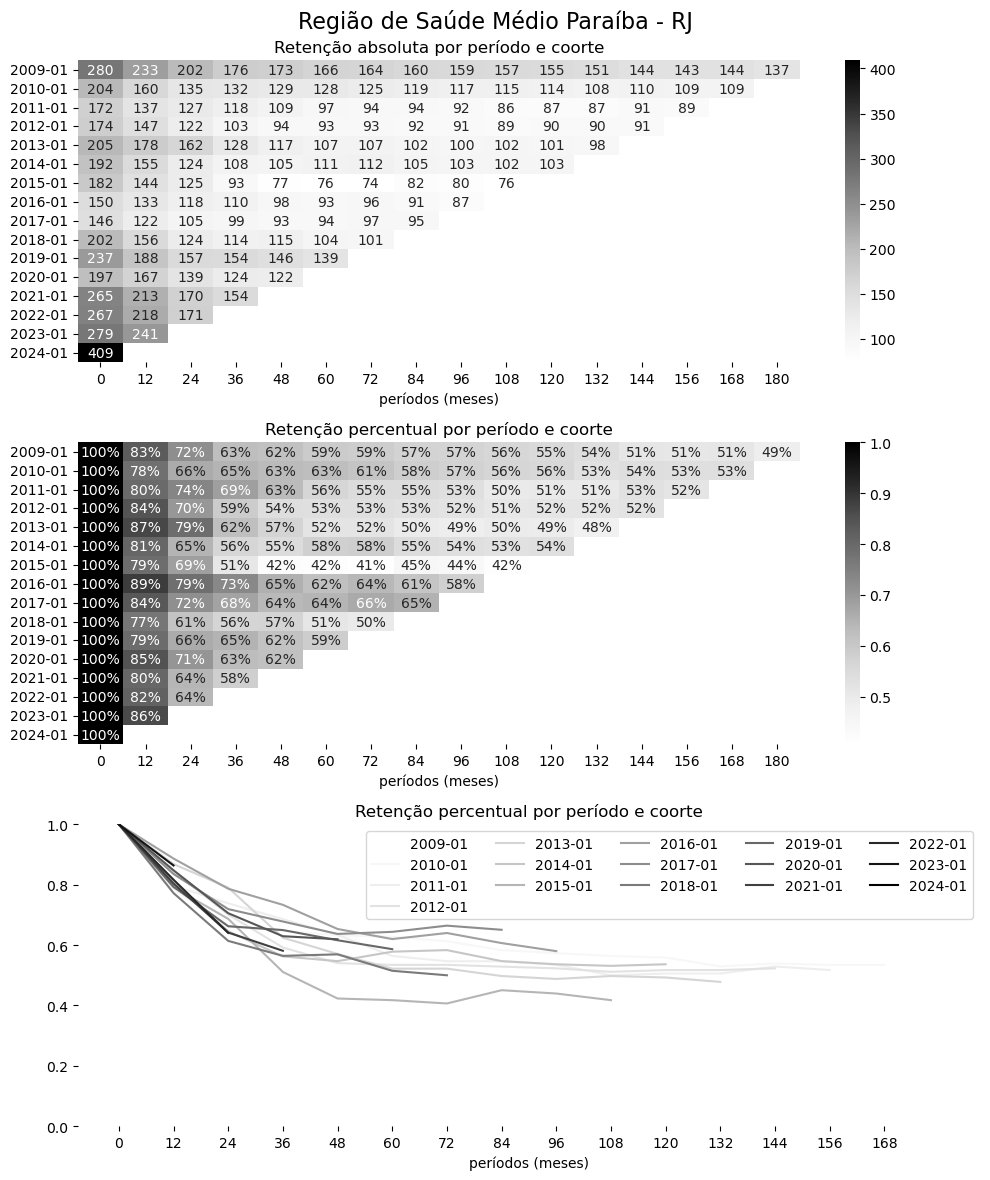

In [24]:
gerar_graficos(exemplo_pivot.copy(), percentual_restantes.copy(), f'Região de Saúde {nome_regiao} - {uf_regiao}', f'{categoria}{regiao_saude}', False)

## Processar os dados e criar os gráficos e arquivos CSV de retenção por região de saúde
Agora o processamento é automatizado para todas as regiões de saúde do Brasil, seguindo os mesmos passos já detalhados anteriormente.

In [ ]:
# Realizar processamento para cada categoria profissional
for categoria in ['Médico']:
#for categoria in df['categoria'].unique():
    df_categoria = df.loc[df['categoria'] == categoria].copy()

    # Criar listas para salvar dados a serem exportados
    triangulos = []
    retencao_ano = []
    retencao_geral = []

    # Realizar o processamento separado para cada região de saúde
    i=0
    for regiao_saude in df['cod_regsaud'].unique():
        try:
            print(f'Processando {regiao_saude} - {i+1}/{len(df["cod_regsaud"].unique())}')
            df_categoria_regiao = df_categoria.loc[df_categoria['cod_regsaud'] == regiao_saude].copy()

            # Agregar os dados por coortes
            coorte_pivot, coorte_sizes = gerar_triangulo_agregado(df_categoria_regiao.copy())

            for fill_na in list(range(0, 181, 12)):
                if fill_na not in coorte_pivot.columns:
                    coorte_pivot[fill_na] = np.nan


            # Calcular profissionais restantes em cada período do coorte
            coorte_pivot.index.set_names([None], inplace=True)
            coorte_pivot.columns.name = None
            coorte_pivot.index = coorte_pivot.index.strftime('%Y-%m')

            # Realizar a divisão de cada célula da tabela pivotada pelo tamanho do grupo para deixar em percentual
            percentual_restantes = calcular_percentual_restantes(coorte_pivot, coorte_pivot[0])

            # Calcular retenção anual (últimos 5 anos) por região de saúde
            retencao_anual = calcular_retencao_ano_regiao(percentual_restantes.copy(), regiao_saude)
            retencao_ano.append(retencao_anual)

            # Calcular retenção geral (média de todo o triangulo)
            retencao_geral.append(pd.DataFrame({'regiao_saude': [regiao_saude], 'retencao_geral': [coorte_pivot.divide(coorte_sizes[0], axis = 0).unstack().mean()]}))

            # Salvar dados do triangulo para exportar em csv
            coorte_pivot['cod_regsaud'] = regiao_saude
            triangulos.append(coorte_pivot.copy())
            coorte_pivot.drop(['cod_regsaud'], axis=1, inplace=True)

            # Gerar gráficos
            nome_regiao = df_categoria_regiao["regiao_saude"].values[0]
            uf_regiao = df_categoria_regiao["uf_sigla"].values[0]
            gerar_graficos(coorte_pivot.copy(), percentual_restantes.copy(), f'Região de Saúde {nome_regiao} - {uf_regiao}', f'{categoria}{regiao_saude}')
            i+=1
        except Exception as e:
            print(f'Erro na região de saúde {regiao_saude}: {e}')
            print(traceback.format_exc())
            continue


    # Exportar dados em CSV
    pd.concat(triangulos).to_csv(f'csvs/{categoria}_triangulos.csv', sep=';')
    pd.concat(retencao_ano).to_csv(f'csvs/{categoria}_retencao_ano.csv', sep=';')
    pd.concat(retencao_geral).to_csv(f'csvs/{categoria}_retencao_geral.csv', sep=';')